In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Study of nominal exchange rate volatility
    Created: Nov 2019
    @author: talespadilha
"""
import os
os.chdir('/Users/talespadilha/Documents/Projects/fx_vol')

import numpy as np
import pandas as pd
import statsmodels.api as sm
import general_functions as gf
from arch import arch_model
from nominal_fx_data import nominal_import
from garch_selection import garch_volatility

import statsmodels.api as sm


def est_ols_ar(series, factors):
    y = series[~series.isna()]
    factors = factors[~series.isna()]
    x = pd.concat([factors.rename('f'), y.shift(1).rename('lag')], axis=1)
    x = sm.add_constant(x)
    mod = sm.OLS(y[1:], x[1:])
    res = mod.fit()

    return res

def est_ols(series, factors):
    x = sm.add_constant(factors.rename('f'))
    y = series[~series.isna()]
    x = x[~series.isna()]
    mod = sm.OLS(y, x)
    res = mod.fit()

    return res


def corr_list(df):
    l=[]
    for i in range(len(df)):
        for j in range(i):
            if i>j:
                l.append(df.iloc[i,j])
    ls = pd.Series(l)
                
    return ls

def garch11(series):
    mod = arch_model(series, p=1, o=0, q=1)
    vol = mod.fit(disp="off").conditional_volatility
    
    return vol


def calc_rv(df, freq='MS'):
    squared=df**2
    final_df = squared.resample(freq).mean()
    
    return final_df
                

path = '/Users/talespadilha/Documents/Oxford/Research/Real Exchange Rate Volatility/Data Files/'


#%% Importing Data
fx = nominal_import('2000-01-01', '2020-06-30', path)
# Adding CLP
clp = pd.read_csv(path+'clp.csv', index_col=0, parse_dates=True)
ids = fx.index[~fx['EUR'].apply(np.isnan)]
fx['CLP'] = clp.loc[ids, :]
fx = fx.reindex(sorted(fx.columns), axis=1)


# Getting returns and getting rid of extreme values
r_fx = (fx.pct_change()*100).dropna(how='all')
r_fx[r_fx>10] = 10
r_fx[r_fx<-10] = -10

EMS, DMS = gf.markets_set(r_fx, path)

Following Engle & Martins (WP) we estimate the following one factor model to control for first moments:

$$ r_{i,t} = \alpha_i + \beta_i f_t + diag\{\sqrt{h_t}\} e_{i,t} $$

where $f_t$ is just the mean return of the exchange rates for day $t$. 

Or alternatively controlling for autocorrelation:

$$ r_{i,t} = \alpha_i + \phi_i r_{i,t-1} + \beta_i f_t + diag\{\sqrt{h_t}\} e_{i,t} $$

We do this in two settings:

* Analysing one factor $f_t$ and considering all 29 countries as part of the same group
* One $f^{EM}_t$ factor for EMs and $f^{DM}_t$ factor for DMs and proceeding separately for EMs and DMs

# Geopolitical Risk and The PPP Puzzle

## Explaining FX Volatility Using a GEOVOL

### Susana Campos-Martins and Tales Padilha

In [58]:
#EMS 
countries = DMS + EMS

f = r_fx[countries].mean(axis=1)

# Estimating the mean factor model
    # First checking the AR behaviour:
t = {}
for country in countries:
    res = est_ols_ar(r_fx[country], f)
    t[country] = res.tvalues['lag']
tstats = pd.Series(t)

e={}
b={}
for country in countries:
    if abs(tstats[country])>1.96:       
        res = est_ols_ar(r_fx[country], f)
    else:
        res = est_ols(r_fx[country], f)
    e[country] = res.resid
    b[country] = res.params
e_hat = pd.concat(e, axis=1)
betas = pd.concat(b, axis=1)


e_hat10 = e_hat*10
v = {}
m = {}
for country in e_hat10:
    v[country] = garch11(e_hat10[country].dropna())  
vol = pd.concat(v, axis=1)/10

std_e = e_hat/vol
se2 = std_e**2

#%% Importing GEOVOL data
x_daily = pd.read_csv(path+'geovols/daily_all.csv', index_col=0)
x_daily.index = pd.to_datetime(x_daily.index, format='%d/%m/%Y')
s = pd.read_csv(path+'geovols/s_all.csv', index_col=0)
x_monthly = x_daily.resample('MS').mean()

g = {}
ccs = list(std_e.columns)
for country in ccs:
    g[country] = (s.loc[country].values * x_daily) + 1 - s.loc[country].values
g = pd.concat(g, axis=1)
g.columns = g.columns.droplevel(1)

# Checking monthly
g_monthly = {}
for country in ccs:
    g_monthly[country] = (s.loc[country].values * x_monthly) + 1 - s.loc[country].values
g_monthly = pd.concat(g_monthly, axis=1)
g_monthly.columns = g_monthly.columns.droplevel(1)

Lets start by taking a look at the correlation in $r_{i,t}$

We will look at cross sectional correlation.

Mean Return Corr: 0.34293323616304394


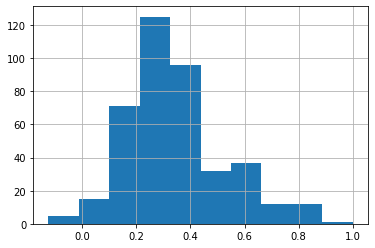

In [59]:
# Returns
corr_list(r_fx[countries].corr()).hist()
print(f"Mean Return Corr: {corr_list(r_fx[countries].corr()).mean()}")

Now looking at standarized residuals $e_{i,t}$

We will look at cross sectional correlation.

Mean Residual Corr: -0.018188932126712833


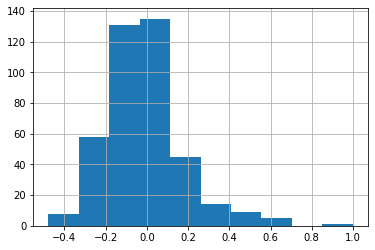

In [60]:
# Standarized residuals
corr_list(std_e.corr()).hist()
print(f"Mean Residual Corr: {corr_list(std_e.corr()).mean()}")

To check common shocks to second moments, lets take a look at the correlation of squared standarized residuals $e^2_{i,t}$

Mean e2 Corr: 0.07942552722753196


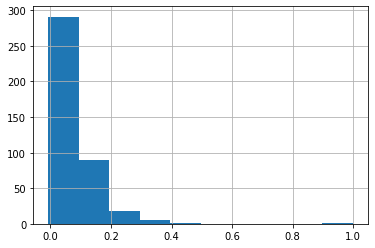

In [61]:
# Squared Residuals
corr_list(se2.corr()).hist()
print(f"Mean e2 Corr: {corr_list(se2.corr()).mean()}")

We will now use the estimated GEOVOL to calculate the correlation in $e^2_{i,t}$ after being standarized by GEOVOL:

$$ \epsilon^2_{i,t} = \frac{e^2_{i,t}}{g(s_i , x_t)} $$

with $ g(s_i , x_t) = s_i x_t + 1 - s_i $

Mean epsilon Corr: 0.018739770988079656


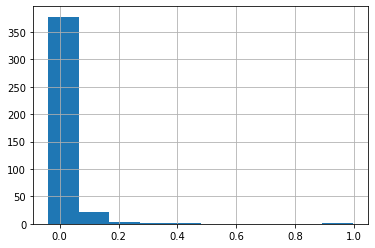

In [62]:
# Epsilon
epsilon = se2 / g
corr_list(epsilon.corr()).hist()
print(f"Mean epsilon Corr: {corr_list(epsilon.corr()).mean()}")

Now looking at realized values in a monthly frequency. That is, we will consider correlation in:

$$ R e_{i,m} = \sum_{t=1}^D \frac{e_{i,t}}{D} $$

Mean Monthly Residual Corr: -0.019728643241094176


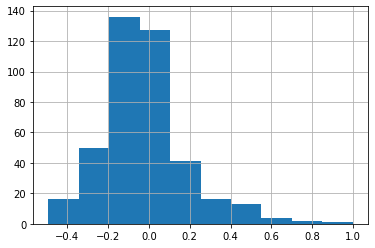

In [63]:
# Taking a look at monthly
month_e = std_e.resample('MS').mean()
corr_list(month_e.corr()).hist()
print(f"Mean Monthly Residual Corr: {corr_list(month_e.corr()).mean()}")

Now looking at realized second moment. That is, we will consider correlation in:

$$ R e_{i,m}^2 = \sum_{t=1}^D \frac{e_{i,t}^2}{D} $$

Mean Monthly Squared Residual Corr: 0.19015278167050337


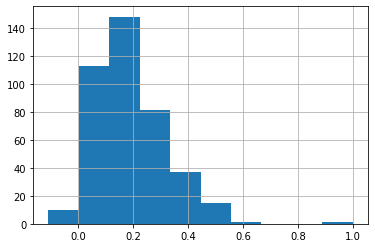

In [64]:
# Taking a look at monthly
month_se2 = se2.resample('MS').mean()
corr_list(month_se2.corr()).hist()
print(f"Mean Monthly Squared Residual Corr: {corr_list(month_se2.corr()).mean()}")

Finally, doing the same for the standarized residual corrected by GEOVOL. That is, we will consider correlation in:

$$ R \epsilon_{i,m}^2 = \sum_{t=1}^D \frac{\epsilon_{i,t}^2}{D} $$

Mean epsilon Corr: 0.07623832358124549


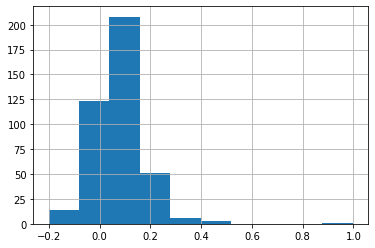

In [66]:
epsilon_m = epsilon.resample('MS').mean()
corr_list(epsilon_m.corr()).hist()
print(f"Mean epsilon Corr: {corr_list(epsilon_m.corr()).mean()}")

In [67]:
#TESTING FOR GEOVOL
psi = epsilon - 1

# Testing for GEOVOL
N = psi.shape[1]
T = psi.shape[0]

a=[]
for i in range(N):
    for j in range(i):
        if i>j:
            for t in range(T):
                a.append(psi.iloc[t,i]*psi.iloc[t,j])
a_series = pd.Series(a)

b=[]
for i in range(N):
    for t in range(T):
        b.append(psi.iloc[t,i]**2)
b_series = pd.Series(b)

xi = np.sqrt((N*T)/((N-1)/2)) * (a_series.sum()/b_series.sum())
print(xi)

19.4844734492696


In [69]:
std_e.min()

EUR    -5.189730
JPY    -5.929012
GBP    -7.739291
AUD    -4.070896
CAD    -4.339716
CHF   -19.126172
HKD   -28.992692
NZD    -4.688109
SEK    -5.012333
SGD    -7.684545
NOK    -6.631202
DKK    -5.189585
ILS    -6.333207
CNY   -18.058640
KRW    -5.334835
MXN    -4.421569
INR    -6.789535
RUB    -4.873017
ZAR    -5.537876
TRY    -7.118357
BRL    -5.338811
TWD    -6.657567
PLN    -5.715049
THB    -5.634633
IDR   -11.736965
HUF    -7.495853
CZK    -6.234041
CLP    -4.247495
PHP    -8.618681
dtype: float64